# EECS 4422 Assignment 3

Jimmy Le<br>
216143992<br>
Prof. Kosta Derpanis<br>
EECS4422 W2023

## Tasks:

o Implement RANSAC based image stitching<br>
o Implement Panorama Construction<br>

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [2]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [3]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [4]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img_gr = img.copy()
    img_gr = cv2.cvtColor(img_gr, cv2.COLOR_RGB2GRAY)
    return img_gr

In [5]:
#Image padding implemented from in class Labs(#2,4)
# Source: https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def pad_images_to_same_size(images):
    """
    :param images: sequence of images
    :return: list of images padded so that all images have same width and height (max width and height are used)
    """
    width_max = 0
    height_max = 0
    for img in images:
        h, w = img.shape[:2]
        width_max = max(width_max, w)
        height_max = max(height_max, h)
    
    width_max = int((width_max) * 1.5)
    height_max = int((height_max) * 1.5)

    images_padded = []
    for img in images:
        h, w = img.shape[:2]
        diff_vert = height_max - h
        pad_top = diff_vert//2
        pad_bottom = diff_vert - pad_top
        diff_hori = width_max - w
        pad_left = diff_hori//2
        pad_right = diff_hori - pad_left
        img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        assert img_padded.shape[:2] == (height_max, width_max)
        images_padded.append(img_padded)

    return images_padded

In [6]:
def euclidan(pair, h):

    a1 = np.transpose([pair[0], pair[1], 1])
    estimate = np.dot(h, a1)
    #estimate = sum([x*y for x,y in zip(h, a1)])
    #print(estimate)
    estimate = estimate/estimate[2]

    a2 = np.transpose([pair[2], pair[3], 1])
    err = a2 - estimate
    return np.linalg.norm(err)

In [7]:
def homography(points):
    #points = np.reshape(points, (4,4))
    matrix = []
    #print(points)
    for p in points:
        #print(p)
        p1 = [p[0],p[1],1]
        p2 = [p[2],p[3],1]
        a1 = [-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0, p2[0] * p1[0], p2[0] * p1[0], p2[0] * p1[2]]
        matrix.append(a1)
        a2 = [0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]]
        matrix.append(a2)
    
    matrix = np.asarray(matrix, dtype=float)
    u, s, v = np.linalg.svd(matrix)

    result = np.reshape(v[8], (3, 3))

    #print(type(result))
    result = (1/result[2][2]) * result
    #print(type(result))

    return result

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [9]:
#Intuition: Kosta's lecture notes & provided example: tinyurl.com/RANSAC-demo (slide 456 of Feature Detection)
def RANSAC(matched,rho):
    
    bestModel = None
    #bestScore = Math.inf 
    bestInliers = []
    inliers = []
    #rand = random.randint(0, matched.shape[0]-1)
    #For a sufficent number of iterations   
    for i in range(2000):
        points = []
        points = [matched[random.randint(0, matched.shape[0]-1)] for k in range(4)]
        h = homography(points)
        #print(type(h))
        inliers = []
        for j in matched:
            d = euclidan(j,h)
            if d < 5:
                inliers.append(j)       
        if len(bestInliers) < len(inliers):
            bestInliers = inliers
            bestModel = h       
        if (len(matched)*rho) < len(bestInliers):
            break  
    return bestModel, bestInliers


## PART A

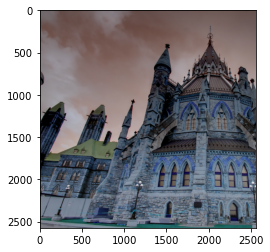

In [10]:
#Read in left
imgLeft = cv2.imread('parliament-left.jpg')
plt.imshow(imgLeft)

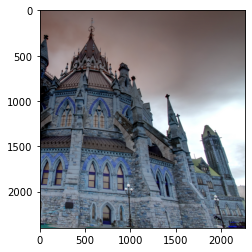

In [11]:
#Read in right
imgRight = cv2.imread('parliament-right.jpg')
plt.imshow(imgRight)

In [12]:
imgLeft, imgRight = pad_images_to_same_size([imgLeft, imgRight])

In [13]:
# imgLeft, imgRight = padImage(imgLeft, imgRight)

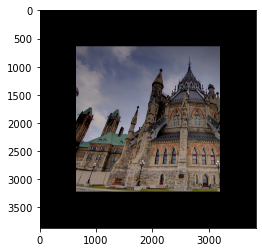

In [14]:
#Convert to rgb
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)
plt.imshow(imgLeft)

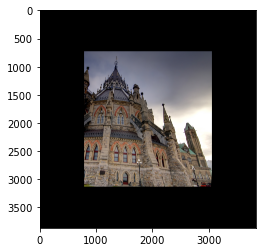

In [15]:
#Convert to rgb
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2RGB)
plt.imshow(imgRight)

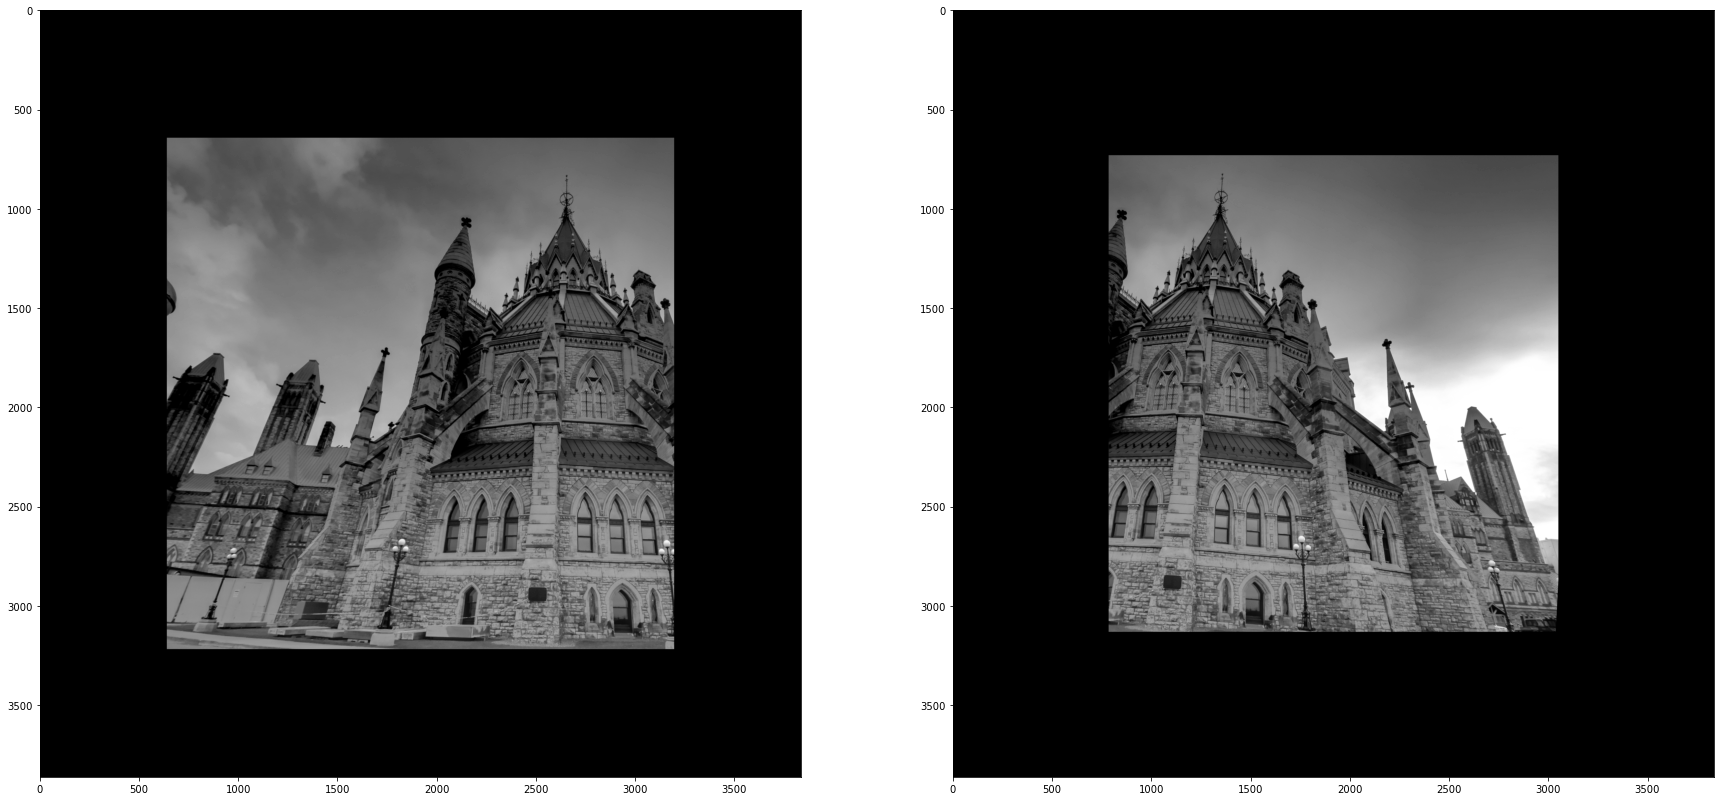

In [16]:
#Step 1, Convert images to grayscale
imgLeft_gr = img2grayscale(imgLeft)
imgRight_gr = img2grayscale(imgRight)
#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(imgLeft_gr)
ax[1].imshow(imgRight_gr)

In [17]:
sift = cv2.SIFT_create()
kp_l, des_l = sift.detectAndCompute(imgLeft_gr,None)


In [18]:
imgLeft = imgLeft.astype(np.float32)/255 
imgRight = imgRight.astype(np.float32)/255 

In [19]:
imgLeft_k = toKornia(imgLeft)
imgRight_k = toKornia(imgRight)

(3862, 3834, 3)
torch.Size([3, 3862, 3834])
torch.Size([1, 3, 3862, 3834])
(3862, 3834, 3)
torch.Size([3, 3862, 3834])
torch.Size([1, 3, 3862, 3834])


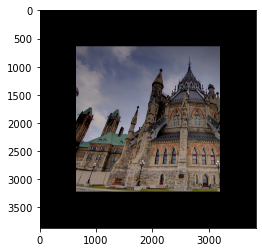

In [20]:
plt.imshow(imgLeft)


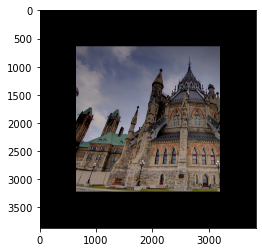

In [21]:
imshowTorch(imgLeft_k)


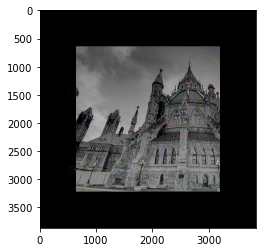

In [22]:
imgLeft_kp = imgLeft.copy()
imgLeft_kp=cv2.drawKeypoints(imgLeft_gr,kp_l,imgLeft_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(imgLeft_kp)

In [23]:
kp_r, des_r = sift.detectAndCompute(imgRight_gr,None)

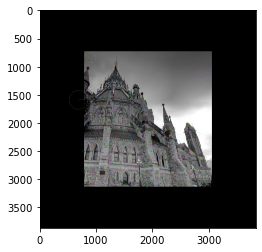

In [24]:
imgRight_kp = imgRight.copy()
imgRight_kp=cv2.drawKeypoints(imgRight_gr,kp_r,imgRight_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(imgRight_kp)

In [25]:
des_l_k = kornia.image_to_tensor(des_l)

In [26]:
des_l_k.shape

torch.Size([1, 16705, 128])

In [27]:
des_l_k = torch.squeeze(des_l_k)

In [28]:
des_l_k.shape

torch.Size([16705, 128])

In [29]:
des_r_k = kornia.image_to_tensor(des_r)
des_r_k = torch.squeeze(des_r_k)

In [30]:
des_r_k.shape

torch.Size([17732, 128])

In [31]:
bf = cv2.BFMatcher()
dis = bf.knnMatch(des_l, des_r, k=2) 
matched1, matched2 = kornia.feature.match_snn(des_l_k, des_r_k)

In [32]:
matched1[0]

tensor([0.7505])

In [33]:
#Step 4, apply thresholding (using threshold = 50)
thresholded = []
for i, j in dis:
    if i.distance < 0.75*j.distance:
        if i.distance < 50:
            thresholded.append([i])
            #thresholded.append([i, matched1[0], matched2[0]])

In [34]:
# #Step 4, apply thresholding (for kornia matched values)
# thresh = []
# for i, j in matched2:
#     if i < 0.75*j:
#         if i < 50:
#             thresh.append([i])

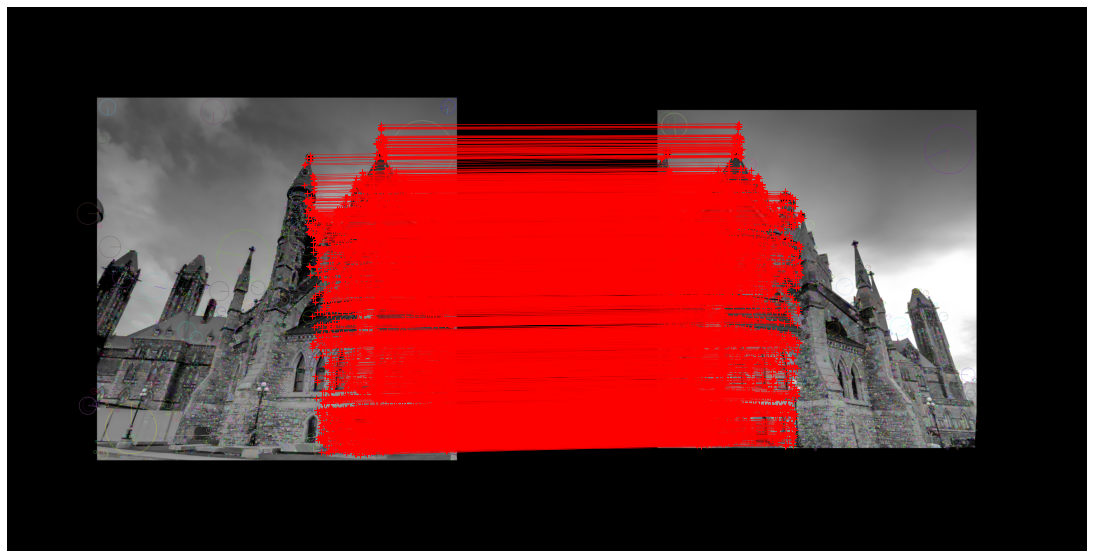

In [35]:
matched = []
for i in thresholded:
    imgLeft_Idx = i[0].queryIdx
    imgRight_Idx = i[0].trainIdx

    [a1,b1] = kp_l[imgLeft_Idx].pt
    [a2,b2] = kp_r[imgRight_Idx].pt
    matched.append([a1,b1,a2,b2])

matched = np.asarray(matched)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imgLeft_kp, imgRight_kp, matched)


In [36]:
len(matched)

3926

In [37]:
matched.shape

(3926, 4)

In [38]:
#Implement/call ransac

In [39]:
matched.shape[0]

3926

In [40]:
points = []

In [41]:
points = [matched[random.randint(0, matched.shape[0]-1)] for i in range(4)]

In [42]:
points

[array([2664.83032227, 1006.20404053, 1359.77050781,  995.23272705]),
 array([3074.59912109, 1402.87060547, 1740.33178711, 1404.30810547]),
 array([2927.92480469, 1996.75097656, 1566.25830078, 1977.79199219]),
 array([2945.05712891, 1928.22558594, 1586.76367188, 1911.62316895])]

In [43]:
# bestModel = None
# #bestScore = Math.inf 
# bestInliers = []
# inliers = []
# #rand = random.randint(0, matched.shape[0]-1)
# #For a sufficent number of iterations   
# for i in range(2000):
#     points = []
#     points = [matched[random.randint(0, matched.shape[0]-1)] for k in range(4)]
#     h = affine(points)
#     #print(type(h))
#     inliers = []

#     for j in matched:
#         d = euclidan(j,h)
#         if d < 5:
#             inliers.append(j)
    
#     if len(inliers) > len(bestInliers):
#         bestInliers = inliers
#         bestModel = h

#     if len(bestInliers) > (len(matched)*0.05):
#         break

In [44]:
bestModel, bestInliers = RANSAC(matched, 0.05)

In [45]:
#h, inliers = RANSAC(matched,.05)

In [46]:
bestModel

array([[ 9.29681819e-01, -5.01256261e-02, -1.11238970e+03],
       [ 2.32050899e-02,  9.45593488e-01, -5.26055629e+01],
       [-1.35143252e-05,  1.02179474e-06,  1.00000000e+00]])

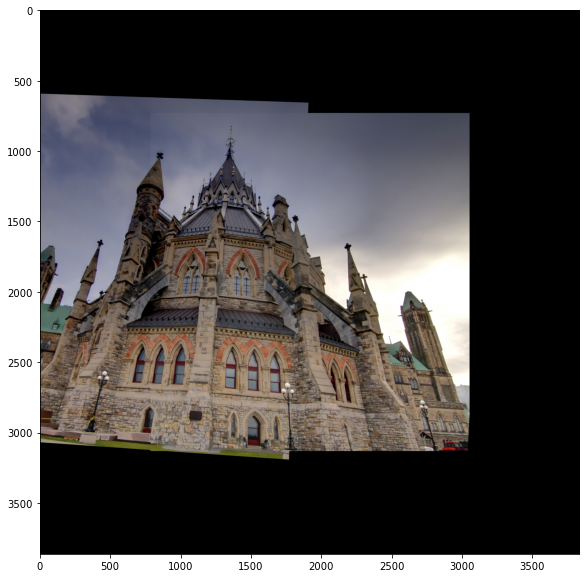

In [47]:
k = torch.tensor(bestModel, dtype = torch.float)
k = k.unsqueeze(0)
(h,w) = imgLeft_k.shape[2:]
out = kornia.geometry.warp_perspective(imgLeft_k,k,(h,w))
maximum = torch.max(out,imgRight_k)
plt.figure(figsize=(10,10))
imshowTorch(maximum)


## Part B

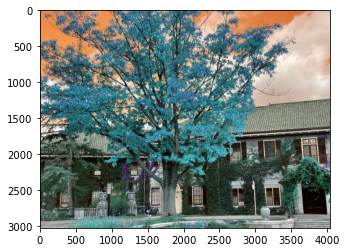

In [48]:
#Read in left
imgLeft = cv2.imread('Glendon-Hall-left.jpg')
plt.imshow(imgLeft)

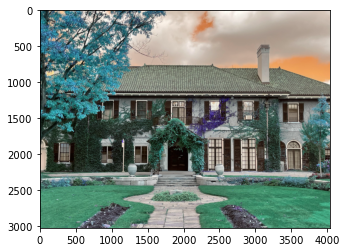

In [49]:
#Read in center
imgCenter = cv2.imread('Glendon-Hall-middle.jpg')
plt.imshow(imgCenter)

In [50]:
imgLeft, imgCenter = pad_images_to_same_size([imgLeft, imgCenter])

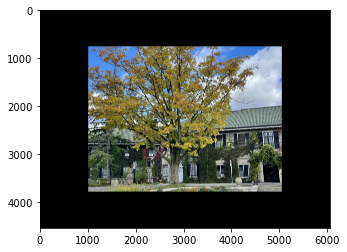

In [51]:
#Convert to rgb
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)
plt.imshow(imgLeft)

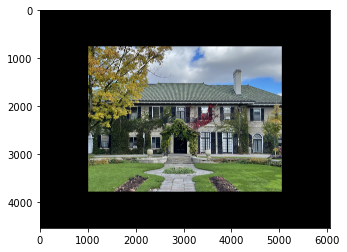

In [52]:
#Convert to rgb
imgCenter = cv2.cvtColor(imgCenter, cv2.COLOR_BGR2RGB)
plt.imshow(imgCenter)

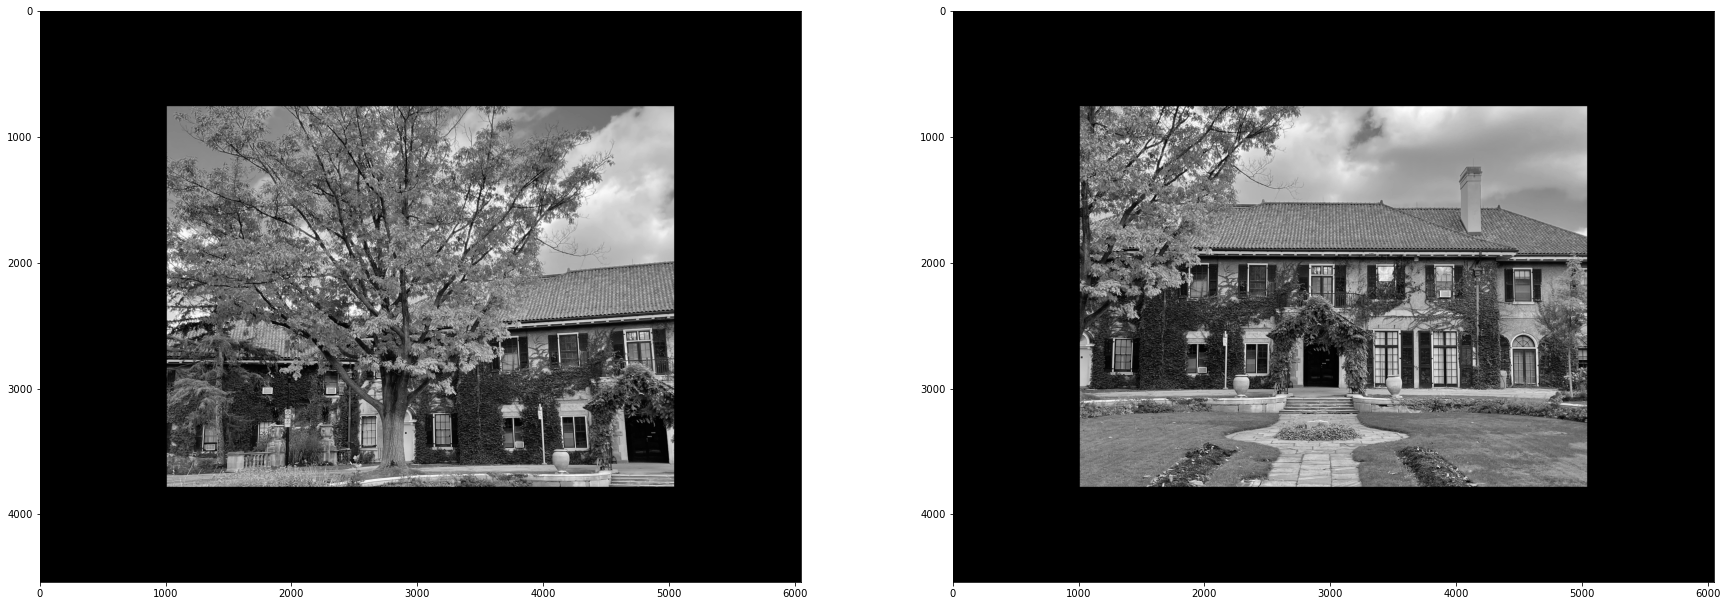

In [53]:
#Step 1, Convert images to grayscale
imgLeft_gr = img2grayscale(imgLeft)
imgCenter_gr = img2grayscale(imgCenter)
#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(imgLeft_gr)
ax[1].imshow(imgCenter_gr)

In [54]:
imgLeft = imgLeft.astype(np.float32)/255
imgCenter = imgCenter.astype(np.float32)/255

In [55]:
imgLeft_k = toKornia(imgLeft)
imgCenter_k = toKornia(imgCenter)

(4536, 6048, 3)
torch.Size([3, 4536, 6048])
torch.Size([1, 3, 4536, 6048])
(4536, 6048, 3)
torch.Size([3, 4536, 6048])
torch.Size([1, 3, 4536, 6048])


In [56]:
sift = cv2.SIFT_create()
kp_l, des_l = sift.detectAndCompute(imgLeft_gr,None)

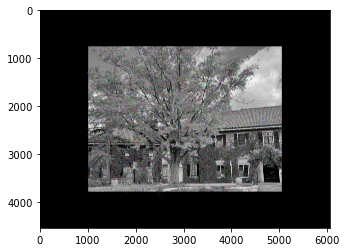

In [57]:
imgLeft_kp = imgLeft.copy()
imgLeft_kp=cv2.drawKeypoints(imgLeft_gr,kp_l,imgLeft_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgLeft_kp)

In [58]:
kp_c, des_c = sift.detectAndCompute(imgCenter_gr,None)

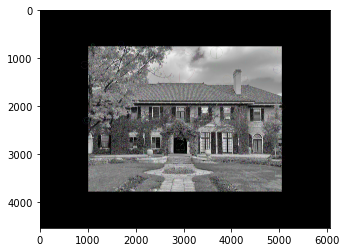

In [59]:
imgCenter_kp = imgCenter.copy()
imgCenter_kp=cv2.drawKeypoints(imgCenter_gr,kp_c,imgCenter_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgCenter_kp)

In [60]:
bf = cv2.BFMatcher()
dis = bf.knnMatch(des_l, des_c, k=2) 
#matched1, matched2 = kornia.feature.match_snn(des_l_k, des_r_k)

In [61]:
#Step 4, apply thresholding (using threshold (rho) = 100)
thresholded = []
for i, j in dis:
    if i.distance < 0.75*j.distance:
        if i.distance < 100:
            thresholded.append([i])
            #thresholded.append([i, matched1[0], matched2[0]])

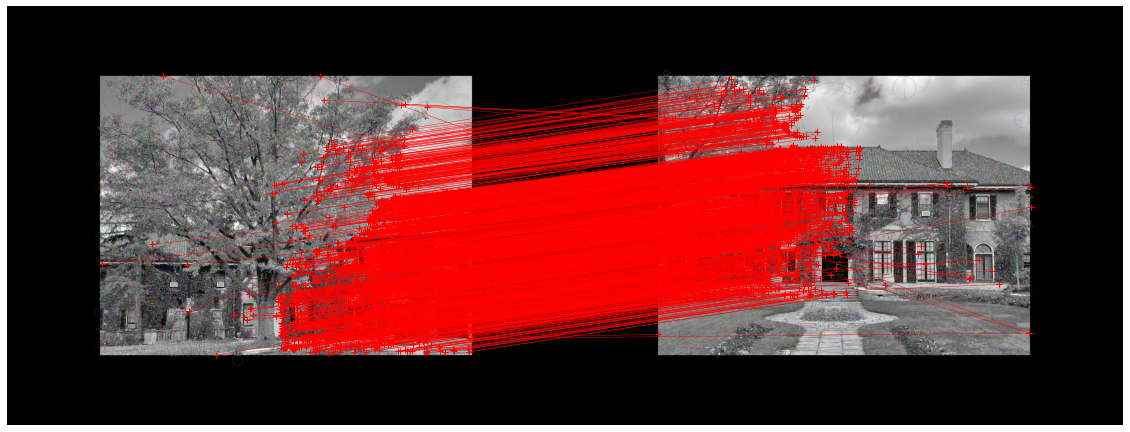

In [62]:
matched = []
for i in thresholded:
    imgLeft_Idx = i[0].queryIdx
    imgCenter_Idx = i[0].trainIdx

    [a1,b1] = kp_l[imgLeft_Idx].pt
    [a2,b2] = kp_c[imgCenter_Idx].pt
    matched.append([a1,b1,a2,b2])

matched = np.asarray(matched)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imgLeft_kp, imgCenter_kp, matched)


In [63]:
bestModel, bestInliers = RANSAC(matched, 0.05)

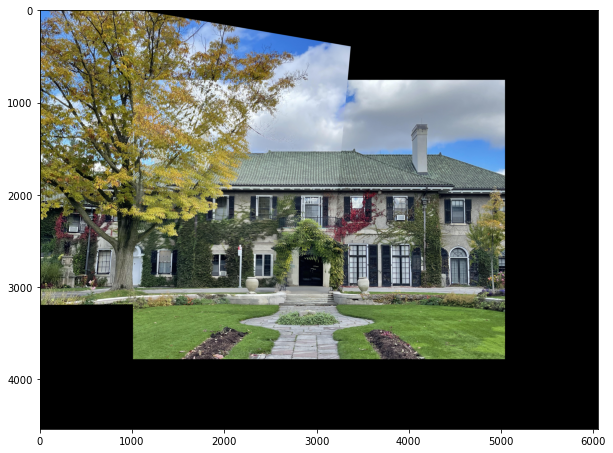

In [64]:
k = torch.tensor(bestModel, dtype = torch.float)
k = k.unsqueeze(0)
(h,w) = imgLeft_k.shape[2:]
out = kornia.geometry.warp_perspective(imgLeft_k,k,(h,w))
maximum = torch.max(out,imgCenter_k)
plt.figure(figsize=(10,10))
imshowTorch(maximum)


In [65]:
imgLeftCenter = kornia.tensor_to_image(maximum)

In [66]:
print(imgLeftCenter)

[[[0.30588233 0.57254905 0.9529412 ]
  [0.30588236 0.57254905 0.9529412 ]
  [0.30588236 0.57254905 0.9529412 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.30588236 0.57254905 0.9529412 ]
  [0.30588236 0.57254905 0.9529412 ]
  [0.30588233 0.572549   0.9529411 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.30588236 0.57254905 0.9529412 ]
  [0.30588236 0.57254905 0.9529412 ]
  [0.3058824  0.57254905 0.9529411 ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [67]:
imgLeftCenter *= 255

In [68]:
imgLeftCenter

array([[[ 77.99999, 146.     , 243.     ],
        [ 78.     , 146.     , 243.     ],
        [ 78.     , 146.     , 243.     ],
        ...,
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ]],

       [[ 78.     , 146.     , 243.     ],
        [ 78.     , 146.     , 243.     ],
        [ 77.99999, 145.99998, 242.99998],
        ...,
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ]],

       [[ 78.     , 146.     , 243.     ],
        [ 78.     , 146.     , 243.     ],
        [ 78.00001, 146.     , 242.99998],
        ...,
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ]],

       ...,

       [[  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ],
        [  0.     ,   0.     ,   0.     ],
        ...,
        [  0.     ,   0.  

In [69]:
imgLeftCenter = imgLeftCenter.astype(np.uint8)

In [70]:
imgLeftCenter

array([[[ 77, 146, 243],
        [ 78, 146, 243],
        [ 78, 146, 243],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 78, 146, 243],
        [ 78, 146, 243],
        [ 77, 145, 242],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 78, 146, 243],
        [ 78, 146, 243],
        [ 78, 146, 242],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

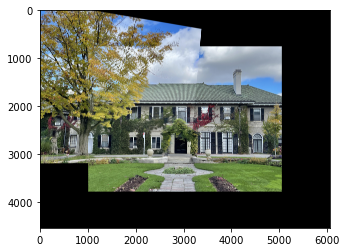

In [71]:
#combinedLeftCenter = kornia.tensor_to_image(maximum)
#combinedLeftCenter = combinedLeftCenter * 255
plt.imshow(imgLeftCenter)

In [72]:
imgRight = cv2.imread('Glendon-Hall-right.jpg')

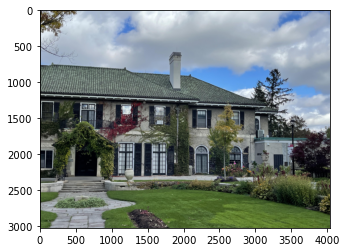

In [73]:
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2RGB)
plt.imshow(imgRight)

In [74]:
imgLeftCenter, imgRight = pad_images_to_same_size([imgLeftCenter, imgRight])

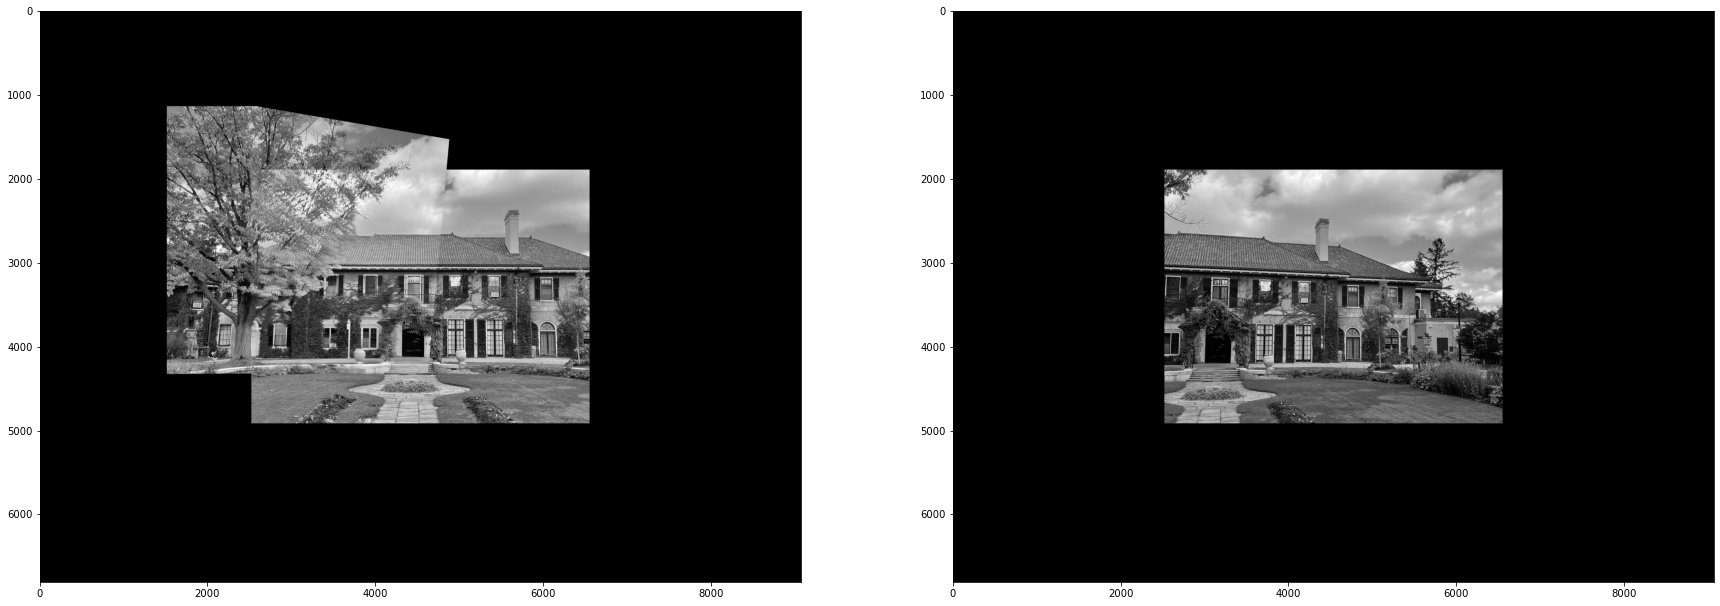

In [75]:
#Step 1, Convert images to grayscale
imgLeftCenter_gr = img2grayscale(imgLeftCenter)
imgRight_gr = img2grayscale(imgRight)
#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(imgLeftCenter_gr)
ax[1].imshow(imgRight_gr)

In [76]:
imgLeftCenter = imgLeftCenter.astype(np.float32)/255
imgRight = imgRight.astype(np.float32)/255 

In [77]:
imgLeftCenter_k = toKornia(imgLeftCenter)
imgRight_k = toKornia(imgRight)

(6804, 9072, 3)
torch.Size([3, 6804, 9072])
torch.Size([1, 3, 6804, 9072])
(6804, 9072, 3)
torch.Size([3, 6804, 9072])
torch.Size([1, 3, 6804, 9072])


In [78]:
kp_lc, des_lc = sift.detectAndCompute(imgLeftCenter_gr,None)

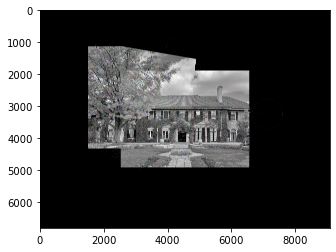

In [79]:
imgLeftCenter_kp = imgLeftCenter.copy()
imgLeftCenter_kp=cv2.drawKeypoints(imgLeftCenter_gr,kp_lc,imgLeftCenter_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgLeftCenter_kp)

In [80]:
kp_r, des_r = sift.detectAndCompute(imgRight_gr,None)

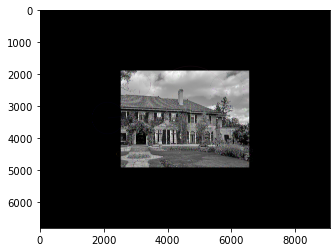

In [81]:
imgRight_kp = imgRight.copy()
imgRight_kp=cv2.drawKeypoints(imgRight_gr,kp_r,imgRight_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(imgRight_kp)

In [82]:
dis = bf.knnMatch(des_lc, des_r, k=2) 
#matched1, matched2 = kornia.feature.match_snn(des_l_k, des_r_k)

In [83]:
#Step 4, apply thresholding (using threshold (rho) = 100)
thresholded = []
for i, j in dis:
    if i.distance < 0.75*j.distance:
        if i.distance < 65:
            thresholded.append([i])
            #thresholded.append([i, matched1[0], matched2[0]])

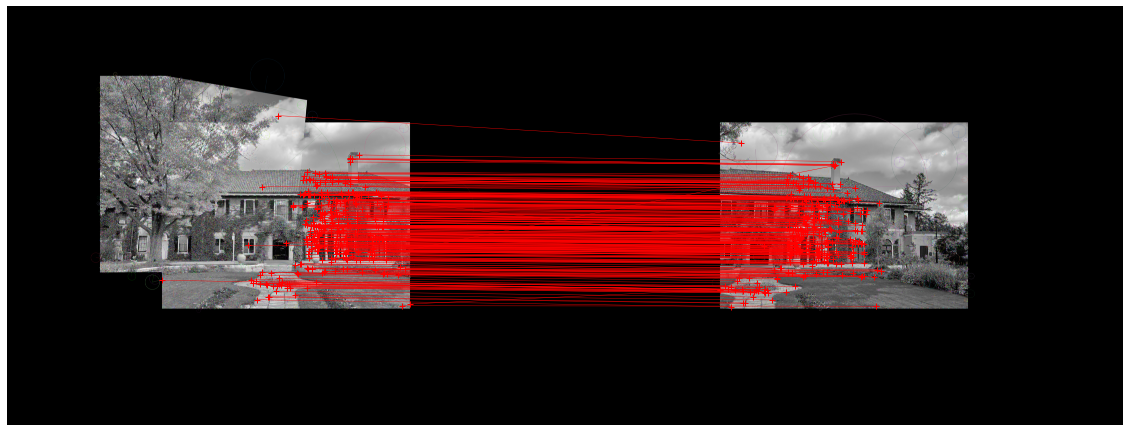

In [84]:
matched = []
for i in thresholded:
    imgLeftCenter_Idx = i[0].queryIdx
    imgRight_Idx = i[0].trainIdx

    [a1,b1] = kp_lc[imgLeftCenter_Idx].pt
    [a2,b2] = kp_r[imgRight_Idx].pt
    matched.append([a1,b1,a2,b2])

matched = np.asarray(matched)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imgLeftCenter_kp, imgRight_kp, matched)


In [85]:
bestModel, bestInliers = RANSAC(matched, 0.05)

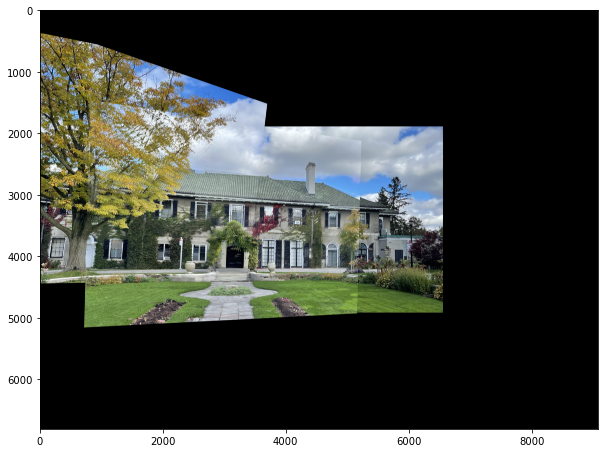

In [86]:
k = torch.tensor(bestModel, dtype = torch.float)
k = k.unsqueeze(0)
(h,w) = imgLeftCenter_k.shape[2:]
out = kornia.geometry.warp_perspective(imgLeftCenter_k,k,(h,w))
maximum = torch.max(out,imgRight_k)
plt.figure(figsize=(10,10))
imshowTorch(maximum)
